In [2]:
import argparse
import numpy as np
from ctypes import CDLL,c_double
fc = CDLL('./fc/libFC.so')

In [3]:
fcAvg = fc.fcAvg
fce = fc.fc
fcAvg.restype=c_double
fce.restype=c_double

In [4]:
m = 0.5*1000
M = 150
N_A=6.02
N_Atimes=23
T = 3
def sensi(sig, t):
    return m/M*N_A*t/sig

In [5]:
# 0nu2b bkg=11
bkg = 11
sigul=fcAvg(c_double(bkg))
print(sigul)

6.969337525131519


In [5]:
fce(c_double(bkg),c_double(0))

0.71

In [6]:
lifeul = sensi(sigul,T)
print(lifeul*10**N_Atimes)

8.637836779022115e+23


# 使用1sigma的限制，2sigma的限制在比较大的resolution时，计算FC会失控

In [6]:
import h5py
with h5py.File('/mnt/stage/douwei/Nd_4245/sensitivity/bkg.h5', 'r') as ipt:
    bkgs = ipt['0nu2b1s'][:]
    bkgs2s = ipt['0nu2b'][:]
    resolutions = ipt.attrs['resolution']

In [97]:
bkgs[0,0]

0.0

In [9]:
# 计算0nu2b的上限
ul0nu2bSmear = np.zeros(bkgs.shape)
for i in range(ul0nu2bSmear.shape[0]):
    for j in range(ul0nu2bSmear.shape[1]):
        #print(bkgs[i,j])
        ul0nu2bSmear[i,j] = fcAvg(c_double(bkgs[i,j]))


KeyboardInterrupt: 

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.size']=20
import matplotlib.pyplot as plt
for i,tl in enumerate([0.1,0.01,0.001]):
    plt.plot(resolutions,ul0nu2bSmear[i], label='{}Hz'.format(tl))
plt.legend()

In [7]:
from scipy.stats import norm
year=3
mass = 500
M=150
eff=norm.cdf(1)-norm.cdf(-1)
print(eff)
def calcsensi(ul,years=3,eff=eff):
    return years*mass/M*6.02/(ul/eff)


0.6826894921370859


In [68]:
bkgs.shape

(3, 31)

In [ ]:
life0nu2bSmear = calcsensi(ul0nu2bSmear)

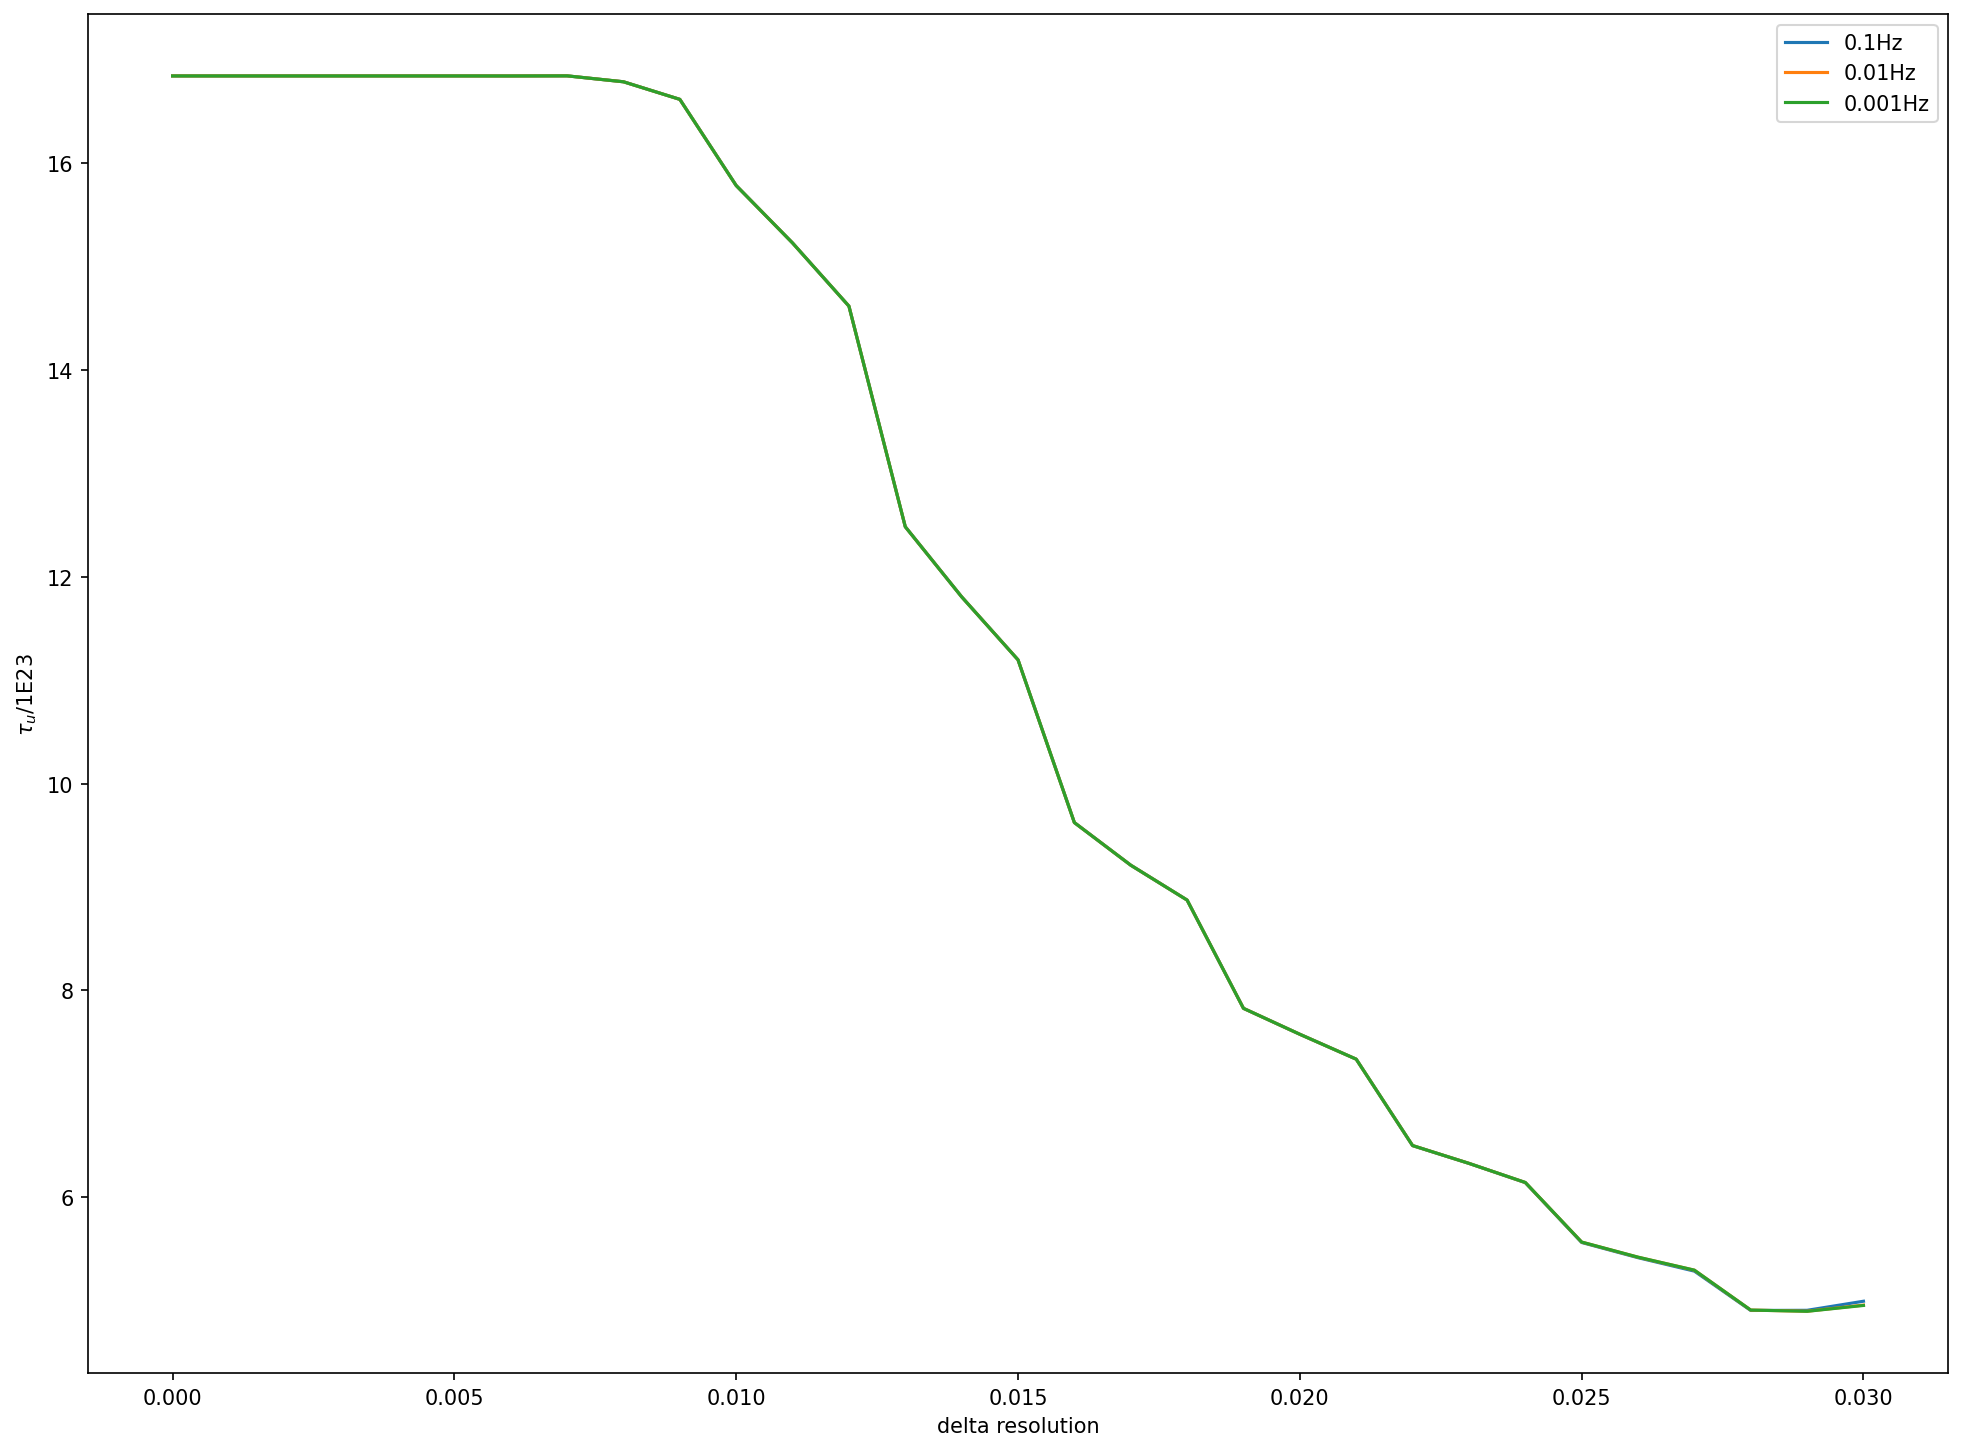

In [33]:
fig, ax = plt.subplots(figsize=(16,12),dpi=150)
for i,tl in enumerate([0.1,0.01,0.001]):
    ax.plot(resolutions,life0nu2bSmear[i], label='{}Hz'.format(tl))
ax.set_xlabel('delta resolution')
ax.set_ylabel(r'$\tau_u$/1E23')
ax.legend()
plt.savefig('life_Tl-resolution.png')

# 随时间变化图

In [8]:
years = np.arange(0.1,6,0.1)

In [9]:

bkgs_t = bkgs[1,0]/3*years
uls_t = np.array([fcAvg(c_double(bkg)) for bkg in bkgs_t])


In [10]:
sensi_t = calcsensi(uls_t,years)

In [11]:
bkgs_tBad = bkgs[0,-1]/3*years
uls_tBad = np.array([fcAvg(c_double(bkg)) for bkg in bkgs_tBad])

In [12]:
sensi_tBad = calcsensi(uls_tBad,years)

In [13]:
np.save('0nu2b.npy',sensi_t)
np.save('0nu2bBad.npy',sensi_tBad)

In [14]:
sensi0nu4b_t=np.load('/mnt/stage/douwei/Nd_4245/sensitivity/0nu4blifechi2.npy')
sensi0nu4b_tBad=np.load('/mnt/stage/douwei/Nd_4245/sensitivity/0nu4blife01chi2.npy')

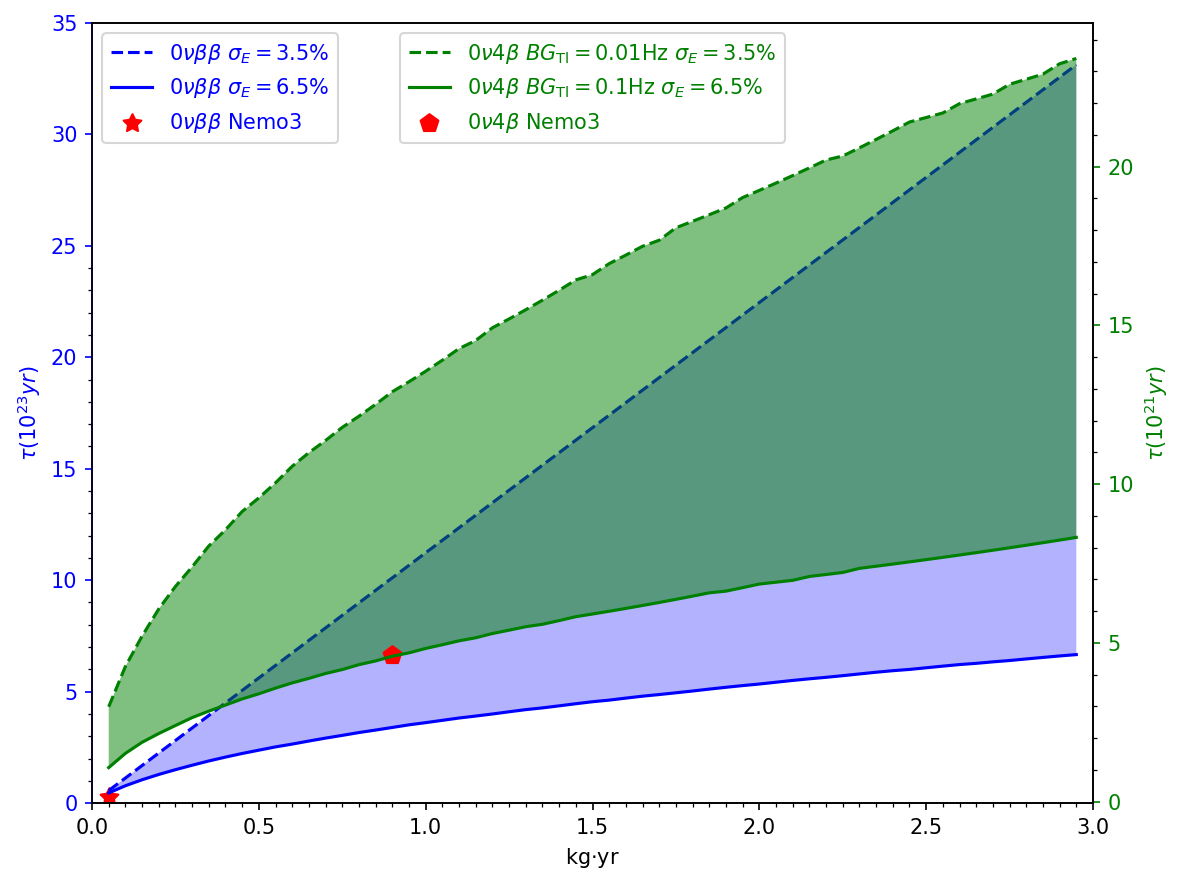

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
xminorLocator = MultipleLocator(0.1)
yminorLocator = MultipleLocator(1)
fig, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.plot(years,sensi_t,label=r'$0\nu\beta\beta$ $\sigma_E=$3.5%',color='b',linestyle='--')
ax.plot(years,sensi_tBad,label=r'$0\nu\beta\beta$ $\sigma_E=$6.5%',color='b')
ax.fill_between(years, sensi_tBad, sensi_t,alpha=0.3,facecolor='b')
ax.scatter(0.1, 0.2/np.log(2),s=80, marker=(5, 1),label=r'$0\nu\beta\beta$ Nemo3', color='r')

ax.set_ylim([0,35])
ax.set_xlim([0,3])
ax2 = ax.twinx()
ax2.plot(years,sensi0nu4b_t*100,label=r'$0\nu4\beta$ $BG_{\mathrm{Tl}}=$0.01Hz $\sigma_E=$3.5%',color='g',linestyle='--')
ax2.plot(years,sensi0nu4b_tBad*100,label=r'$0\nu4\beta$ $BG_{\mathrm{Tl}}=$0.1Hz $\sigma_E=$6.5%',color='g')
ax2.fill_between(years, sensi0nu4b_tBad*100, sensi0nu4b_t*100,alpha=0.5,facecolor='g')
ax2.scatter(1.8, 3.2/np.log(2),s=80, marker=(5, 0),label=r'$0\nu4\beta$ Nemo3', color='r')
#ax2.set_ylim([0.05,0.25])

ax.legend(labelcolor='b')
ax.set_xlabel('kg$\cdot$yr')
ax.set_ylabel(r'$\tau$($10^{23}yr$)')
ax.yaxis.label.set_color('b')
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.set_xticks(np.arange(7))
ax.set_xticklabels(np.arange(7)*0.5)
ax.tick_params(axis='y', colors='b')
ax.spines['left'].set_color('b')
ax2.set_ylabel(r'$\tau$($10^{21}yr$)')
ax2.yaxis.label.set_color('g')
ax2.xaxis.set_minor_locator(xminorLocator)
ax2.yaxis.set_minor_locator(yminorLocator)
#ax2.yaxis.set_color
ax2.tick_params(axis='y', colors='g')
ax2.legend(loc='upper center',labelcolor='g')
plt.tight_layout()
plt.savefig('estimatelife.pdf')

In [99]:
bkgs_t2s = bkgs2s[1,0]/3*years
uls_t2s = np.array([fcAvg(c_double(bkg)) for bkg in bkgs_t2s])
sensi_t2s = calcsensi(uls_t2s,years,eff=norm.cdf(2)-norm.cdf(-2))

In [ ]:
bkgs_tBad2s = bkgs2s[0,-1]/3*years
uls_tBad2s = np.array([fcAvg(c_double(bkg)) for bkg in bkgs_tBad2s])

In [ ]:
sensi_tBad2s = calcsensi(uls_tBad2s,years)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
xminorLocator = MultipleLocator(0.1)
yminorLocator = MultipleLocator(1)
fig, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.plot(years,sensi_t2s,label=r'$0\nu\beta\beta$ 0.01Hz 3.5%',color='b',linestyle='--')
ax.plot(years,sensi_tBad2s,label=r'$0\nu\beta\beta$ 0.1Hz 6.5%',color='b')
ax.fill_between(years, sensi_tBad2s, sensi_t2s,alpha=0.3,facecolor='b')
ax.scatter(0.1, 0.18/np.log(2),s=80, marker=(5, 1),label=r'$0\nu\beta\beta$ Nemo3', color='r')

#ax.set_ylim([0,35])
ax.set_xlim([0,3])
ax2 = ax.twinx()
ax2.plot(years,sensi0nu4b_t*100,label=r'$0\nu4\beta$ 0.01Hz 3.5%',color='g',linestyle='--')
ax2.plot(years,sensi0nu4b_tBad*100,label=r'$0\nu4\beta$ 0.1Hz 6.5%',color='g')
ax2.fill_between(years, sensi0nu4b_tBad*100, sensi0nu4b_t*100,alpha=0.3,facecolor='g')
ax2.scatter(1.8, 3.2/np.log(2),s=80, marker=(5, 0),label=r'$0\nu4\beta$ Nemo3', color='r')
#ax2.set_ylim([0.05,0.25])

ax.legend(labelcolor='b')
ax.set_xlabel('kg$\cdot$yr')
ax.set_ylabel(r'$\tau$($10^{23}yr$)')
ax.yaxis.label.set_color('b')
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.set_xticks(np.arange(7))
ax.set_xticklabels(np.arange(7)*0.5)
ax.tick_params(axis='y', colors='b')
ax.spines['left'].set_color('b')
ax2.set_ylabel(r'$\tau$($10^{21}yr$)')
ax2.yaxis.label.set_color('g')
ax2.xaxis.set_minor_locator(xminorLocator)
ax2.yaxis.set_minor_locator(yminorLocator)
#ax2.yaxis.set_color
ax2.tick_params(axis='y', colors='g')
ax2.legend(loc='upper center',labelcolor='g')
plt.tight_layout()
plt.savefig('estimatelife2s.pdf')